In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# Import the data

In [6]:
player_df = pd.read_csv('../data/nhl-player-data.csv')
team_df = pd.read_csv('../data/nhl-teams.csv')

## Rename columns based on provided README to make them more approachable

In [7]:
player_df = player_df.rename({
    'Rk': 'rank',
    'Age': 'age',
    'Player': 'player',
    'Pos': 'position',
    'Tm': 'team',
    'GP': 'games_played',
    'G': 'goals',
    'A': 'assists',
    'PTS': 'points',
    'plusminus': 'plus_minus',
    'PIM': 'penalty_minutes',
    'PS': 'team_points_ratio',
    'EV': 'num_goals_5on5',
    'PP': 'num_goals_powerplay',
    'SH': 'num_goals_shorthanded',
    'GW': 'num_goals_gamewinning',
    'EV.1': 'num_assists_5on5',
    'PP.1': 'num_assists_powerplay',
    'SH.1': 'num_assists_shorthanded',
    'GW.1': 'num_assists_gamewinning',
    'S': 'shoots_on_goal',
    'S_percent': 'shoot_success_rate',
    'TOI': 'time_on_ice',
    'ATOI': 'average_time_on_ice',
    'BLK': 'num_blocked_shots',
    'HIT': 'num_hits',
    'FOW': 'faceoff_wins',
    'FOL': 'faceoff_losses',
    'FO_percent': 'faceoff_success_rate',
    'HART': 'num_HT_wins',
    'Votes': 'num_HT_votes',
    'Season': 'season'
}, axis=1)

In [8]:
player_df

,rank,player,Nick,age,position,team,games_played,goals,assists,points,plus_minus,penalty_minutes,team_points_ratio,num_goals_5on5,num_goals_powerplay,num_goals_shorthanded,num_goals_gamewinning,num_assists_5on5,num_assists_powerplay,num_assists_shorthanded,shoots_on_goal,shoot_success_rate,time_on_ice,average_time_on_ice,num_blocked_shots,num_hits,faceoff_wins,faceoff_losses,faceoff_success_rate,num_HT_wins,num_HT_votes,season
0,1,Connor McDavid,mcdavco01,20,C,EDM,82,30,70,100,27,26,12.8,26,3,1,6,45,24,1,251,12.0,1733,21.133333,29.0,34,348.0,458.0,43.2,1,1604,2017
1,2,Sidney Crosby,crosbsi01,29,C,PIT,75,44,45,89,17,24,12.3,30,14,0,5,34,11,0,255,17.3,1491,19.883333,27.0,80,842.0,906.0,48.2,0,1104,2017
2,3,Patrick Kane,kanepa01,28,RW,CHI,82,34,55,89,11,32,10.8,27,7,0,5,39,16,0,292,11.6,1754,21.400000,15.0,28,7.0,44.0,13.7,0,206,2017
3,4,Nicklas Backstrom,backsni02,29,C,WSH,82,23,63,86,17,38,9.9,15,8,0,5,36,27,0,162,14.2,1497,18.266667,33.0,45,685.0,648.0,51.4,0,60,2017
4,5,Nikita Kucherov,kucheni01,23,RW,TBL,74,40,45,85,13,38,12.0,23,17,0,7,30,15,0,246,16.3,1438,19.433333,20.0,30,0.0,0.0,0.0,0,119,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12323,886,Zach Trotman,trotmza01,27,D,PIT,3,0,0,0,-3,0,-0.2,0,0,0,0,0,0,0,6,0.0,38,12.800000,2.0,1,0.0,0.0,NaN,0,0,2018
12324,887,Dominic Turgeon,turgedo01,21,C,DET,5,0,0,0,-2,2,-0.2,0,0,0,0,0,0,0,3,0.0,46,9.200000,8.0,3,7.0,14.0,33.3,0,0,2018
12325,888,Rinat Valiev,valieri01,22,D,MTL,2,0,0,0,0,2,0.0,0,0,0,0,0,0,0,2,0.0,24,11.800000,2.0,0,0.0,0.0,NaN,0,0,2018
12326,889,Curtis Valk,valkcu01,24,LW,FLA,1,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,NaN,3,3.400000,0.0,1,0.0,3.0,0.0,0,0,2018


## Drop evidently useless columns

In [9]:
player_df.drop('Nick', axis=1, inplace=True, errors='ignore')

# 1. Basic data exploration

First let's have a look at basic data visualization of the variables we are interested in.

## 1.1 The **goals** variable

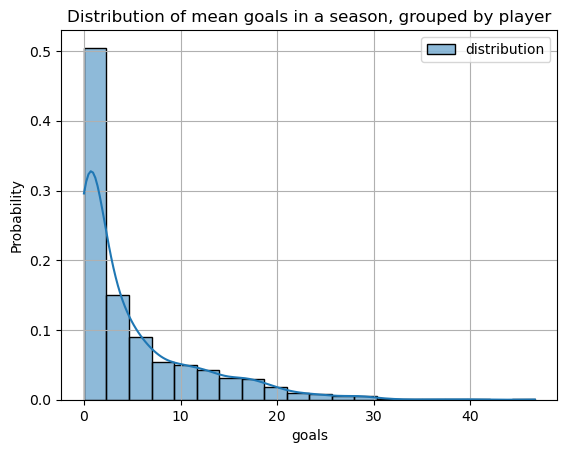

In [10]:
fig, ax = plt.subplots()
sns.histplot(player_df.groupby('player').agg({'goals': 'mean'})['goals'],
             stat='probability',
             bins=20,
             kde=True,
             ax=ax,
             label='distribution')
ax.grid()
ax.legend()
ax.plot()
ax.set_title('Distribution of mean goals in a season, grouped by player');

Now let's explore the correlation between the number of goals scored and other (numerical) variables.

''

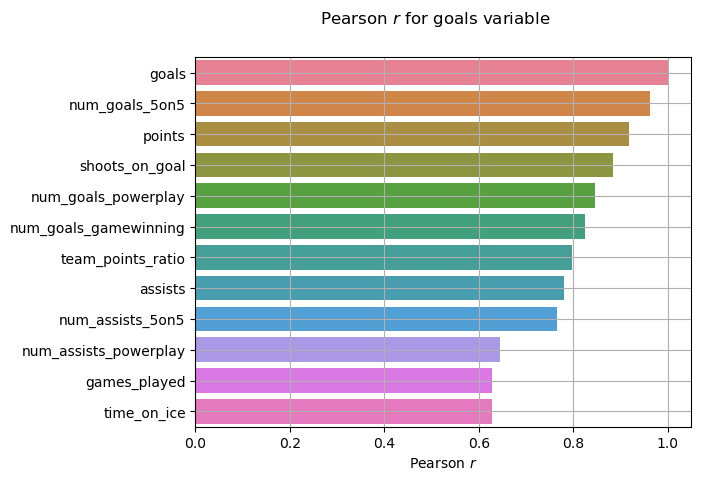

In [11]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

goal_corr_df = pd.DataFrame(player_df.select_dtypes(include=numerics).corr()['goals'].sort_values(ascending=False))
plot_df = goal_corr_df[goal_corr_df.goals.abs() > 0.5]
fig, ax = plt.subplots()
sns.barplot(plot_df.T, orient='h', ax=ax)
ax.set_xlabel(rf'Pearson $r$')
fig.suptitle(rf'Pearson $r$ for goals variable')
ax.grid()
;

## 1.2 Player being traded in the next season

In [12]:
player_df['traded_next_season'] = np.nan
for row_idx in tqdm(range(len(player_df)), 'Creating the traded feature'):
    player = player_df.iloc[row_idx]
    player_records = player_df[player_df.player == player.player]
    next_season = player_records[player_records.season == player.season - 1]
    if len(next_season) == 1:
        team = next_season.iloc[0].team
        player_df.loc[row_idx, 'traded_next_season'] = float(team != player.team)


Creating the traded feature:   0%|          | 0/12328 [00:00<?, ?it/s]

''

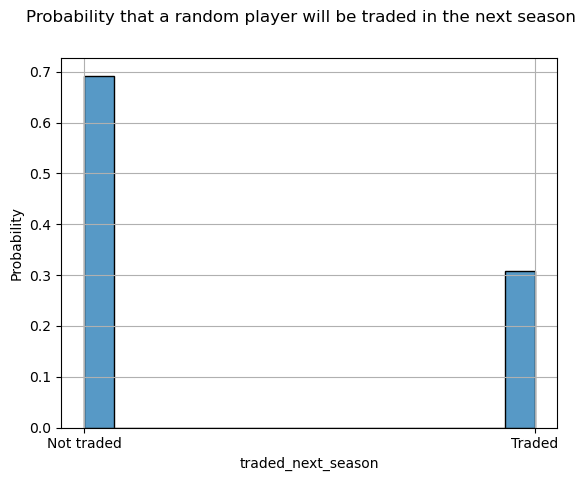

In [13]:
fig, ax = plt.subplots()
sns.histplot(player_df.traded_next_season,
             stat='probability',
             ax=ax)
ax.set_xticks([0, 1], ['Not traded', 'Traded'])
ax.grid()
fig.suptitle('Probability that a random player will be traded in the next season')
;

''

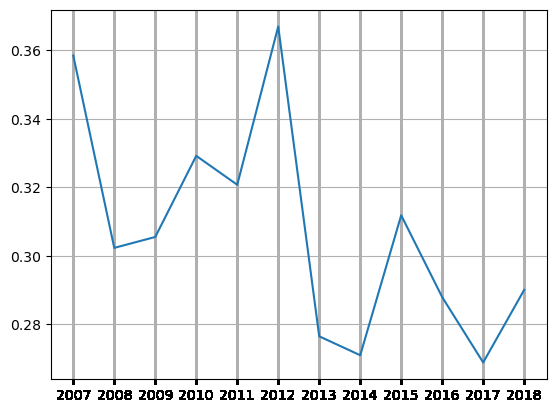

In [32]:
fig, ax = plt.subplots()

vals = []
for season in tqdm(sorted(player_df.season)):
    df_filtered = player_df[player_df.season == season]
    df_filtered = df_filtered[~df_filtered.traded_next_season.isna()]
    if len(df_filtered) == 0:
        continue
    else:
        vals.append((season, sum(df_filtered.traded_next_season) / len(df_filtered)))
    
ax.plot([v[0] for v in vals], [v[1] for v in vals])
ax.set_xticks([v[0] for v in vals])
ax.grid()
# fig.suptitle('Probability that a random player will be traded in the next season')
;

Let's see the trend between seasons.

Now let's observe what correlation is there between being traded in the next season and other variables.

In [14]:
df_filtered = player_df[~player_df.traded_next_season.isna()]

trade_df = pd.DataFrame(df_filtered.select_dtypes(include=numerics))
trade_df.dropna(inplace=True)
X = trade_df[list(set(trade_df.columns) - set(['traded_next_season']))]
y = trade_df[['traded_next_season']].values[:, 0]

model = LogisticRegression(fit_intercept=True,
                           max_iter=1_000,
                           penalty='l1',
                           solver='liblinear')
model.fit(X, y)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [15]:
accuracy_score(y, model.predict(X))

0.6953331729612702

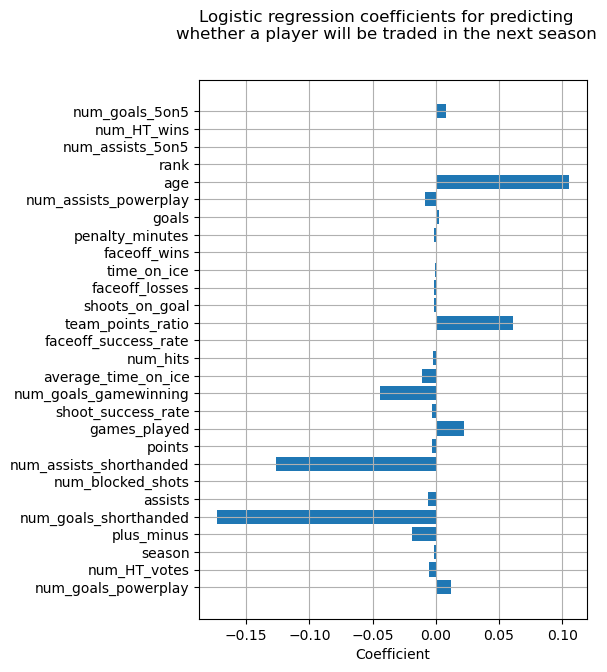

In [16]:
fig, ax = plt.subplots(figsize=(5, 7))
ax.barh(X.columns, width=model.coef_[:][0])
fig.suptitle('Logistic regression coefficients for predicting\nwhether a player will be traded in the next season')
ax.set_xlabel('Coefficient')
ax.grid()

## 1.3 Hart Trophy votes

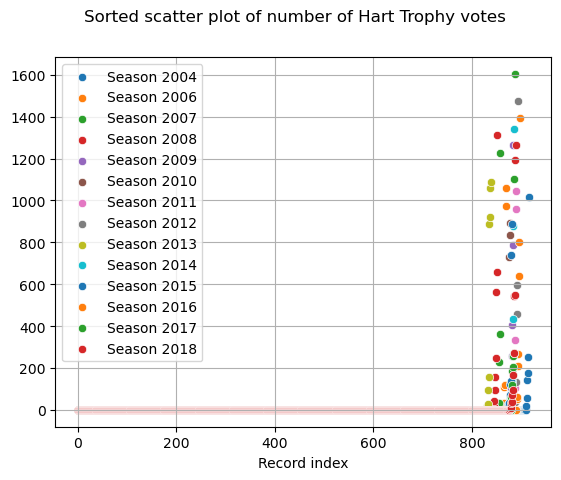

In [23]:
fig, ax = plt.subplots()
for season in sorted(player_df.season.unique()):
    _df = player_df[player_df.season == season]
    sns.scatterplot(sorted(_df.num_HT_votes), label=f'Season {season}')
ax.set_xlabel('Record index')
fig.suptitle('Sorted scatter plot of number of Hart Trophy votes')
ax.grid()

Create votes in the next season column

In [18]:
player_df['num_HT_votes_next_season'] = np.nan
for season in tqdm(sorted(player_df.season.unique())):
    next_season = season + 1
    if next_season not in player_df.season:
        break
    for player_name in player_df.player.unique():
        filter_1 = player_df.season == next_season
        filter_2 = player_df.player == player_name
        df_filtered = player_df[filter_1 & filter_2]
        if len(df_filtered) == 0:
            continue
        filter_3 = player_df.season == season
        player_df.loc[filter_2 & filter_3, 'num_HT_votes_next_season'] = df_filtered.iloc[0].num_HT_votes

  0%|          | 0/14 [00:00<?, ?it/s]

''

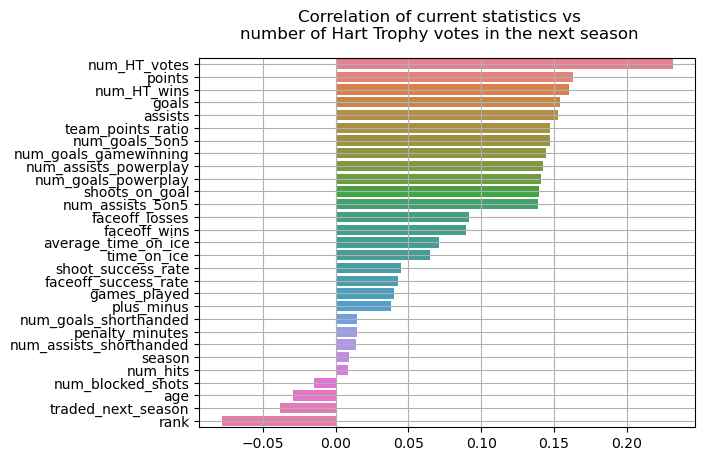

In [19]:
not_nan = player_df[~player_df.num_HT_votes_next_season.isna()].copy()
corr_with_numerics = pd.DataFrame(not_nan.select_dtypes(include=numerics) \
        .corr()['num_HT_votes_next_season'] \
        .sort_values(ascending=False)).iloc[1:]


fig, ax = plt.subplots()
sns.barplot(corr_with_numerics.T, orient='h')
ax.grid()
fig.suptitle('Correlation of current statistics vs\nnumber of Hart Trophy votes in the next season')
;